# **<center>Livrable 2</center>**
<center>Quentin Trappier – Hugo Durupt – Enzo Marcelli – Fabien Arrighi</center>

___

## I. Introduction

Avec la nécessité de prendre en compte l'écologie, des mesures sont à prendre afin d'optimiser les processus de livraison. Nous représentons une entreprise nommée CesiCDP dont l'objectif est de trouver des solutions pour aider à la transition écologique et technologique. L'ADEME propose des financements pour les entreprises proposant des solutions de mobilité plus écologiques et responsable. Il s'agirait pour notre entreprise d'arriver à trouver une solution algorithmique permettant de calculer sur un réseau routier une tournée permettant de relier entre elles un sous-ensemble de villes, puis de revenir à son point de départ, de manière à minimiser la durée totale de la tournée.

<center><img src="img/projet_1.png"/></center>

Le schema ci-dessus montre les routes que nous devons optimiser.

## II. Modélisation

### 1. Problème de décision

Pour mieux comprendre le projet et les demandes, nous allons écrire le problème de décision associé aux demandes. Pour ce faire, nous allons avoir besoin de décrire d’abord les données en entrées. 
Les données en entrées sont des données représentant un graphe. Le meilleur moyen de représenter un graphe est la matrice d’adjacence. En effet, nous aurions pu utiliser une liste d’adjacence, mais celle-ci est optimale dans les cas où le graphe est peu dense. Or, dans notre cas, le graphe risque d’être dense, nous priorisons donc une matrice d’adjacence. Cette matrice d’adjacence ``A`` de dimension ``n * n``, où ``n`` est le nombre de sommets du graphe. Chaque élément ``A[i][j]`` indique le poids de l'arête entre les sommets ``i`` et ``j``, avec ``A[i][j] = 0`` si aucune arête n'existe entre ``i`` et ``j``.
Après avoir défini les données, nous allons décrire le problème de décision :

<center style="font-weight:bold;">Existe-t-il un cycle C qui passe par tous les sommets tel que la somme des poids des arêtes de C soit ≤k ?</center>

Nous pouvons trouver un problème d’optimisation, permettant de trouver une solution encore plus optimale :

<center style="font-weight:bold;">Trouver un cycle C qui passe par tous les sommets tel que la somme des poids des arêtes de C soit minimale.</center>

### 2. Classe de complexité

Le problème à résoudre est NP-complet. Pour le prouver, il faut montrer que :

- Le problème se vérifie en temps polynomial.
- Le problème peut être réduit de façon polynomiale à un autre problème. 

Pour prouver que le problème se vérifie en temps polynomial, il faut regarder ce que renverra notre algorithme, et les données en entrée. Le programme retournera une chaîne de caractères ou une liste, représentant le cycle retourné. De plus, le poids total du cycle est retourné, représentant le nombre de kilomètres parcourus pour retourner jusqu’au point de départ.
>Par exemple :
>
>["A", "D", "B", "C", "E", "A"], 15

Ici, on a un cycle qui commence par le point ``A`` puis passe par le ``D`` puis le ``B`` puis le ``E`` et reviens au ``A``. Le poids total (dont la valeur représente des kilomètres), est de 15.
Pour vérifier que le problème est vérifiable en temps polynomial, il faut regarder si ce chemin est un cycle valide. Pour ce faire, nous pouvons parcourir les sommets retournés et vérifier si tel et tel sommet sont bien connectés par une arête grâce aux données en entrée (le graphe). De plus, pendant le parcours de ce cycle, si l’arrête est correcte, on additionne le poids de l’arête a un poids total. Cela permettra de vérifier à la fin du parcours, si en plus de savoir que le cycle est valide, que le poids correspond bien au poids du chemin. Le parcours de cycle dans le cadre de graphe se fait en temps polynomial. La première étape est donc vérifiée.
La deuxième étape consiste à faire une réduction polynomiale de ce problème. Pour ce faire, il faut trouver un autre problème NP-complet. Il se trouve que notre problème s’apparente à un autre problème, le problème du voyageur. En effet, le problème du voyageur consiste à trouver un circuit le plus petit qui passe exactement une fois par chaque ville (représentée par des sommets) et revient au sommet de départ. La seule différence étant que dans notre cas, nous pouvons repasser plusieurs fois sur un sommet, si nécessaire. Par exemple, nous serons forcés de repasser par le sommet de départ (ou ville de départ), car pour atteindre certaines villes, il faut repasser par celle-ci. Le problème reste néanmoins une réduction polynomiale du problème du voyageur.

## III. Implémentation et exploitation

### 1. Choix des algorithmes

#### Importation de tous les modules nécessaire pour la suite

In [ ]:
import time
import pulp
import random
import numpy as np
import networkx as nx
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import Delaunay
from sklearn.cluster import KMeans
from ipywidgets import IntProgress
from IPython.display import display

### 2. Modélisation des villes

#### Création de la classe ``Cities``

In [121]:
class Cities:
    cities = []

    def __init__(self, nb_nodes: int, x_range: tuple[int, int], y_range: tuple[int, int], seed: int=None) -> None:
        self.x_range = x_range
        self.y_range = y_range
        if seed:
            random.seed(seed)
        else:
            seed = int(str(time.time()).split('.')[1][-4:])
            random.seed(seed)
        used_coordinates = set()

        while len(self.cities) < nb_nodes:
            x = random.randint(self.x_range[0], self.x_range[1])
            y = random.randint(self.y_range[0], self.y_range[1])

            if (x, y) not in used_coordinates:
                used_coordinates.add((x, y))
                self.cities.append((len(self.cities) + 1, x, y))

    def calculateDistance(self, city_1: int, city_2: int) -> float:
        city_1 = self.cities[city_1 - 1]
        city_2 = self.cities[city_2 - 1]
        return ((city_1[1] - city_2[1])**2 + (city_1[2] - city_2[2])**2)**0.5

    def calculateDistanceFromCenter(self, city: int) -> float:
        city = self.cities[city - 1]
        return ((city[1] - self.x_range[1]/2)**2 + (city[2] - self.y_range[1]/2)**2)**0.5

    def getCenterCity(self) -> tuple[int, int, int]:
        distances = [(point, self.calculateDistanceFromCenter(point[0])) for point in self.cities]
        return min(distances, key=lambda x: x[1])[0]

#### Création de la classe ``Graph``

In [122]:
class Graph:
    def __init__(self, data: tuple[int, int, int], title: str="", xlabel: str="X Coordinate", ylabel: str="Y Coordinate", figsize: tuple[int, int]=(10, 10)) -> None:
        self.data = data
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.figsize = figsize

    def scatterPlot(self, **kwargs) -> None:
        plt.figure(figsize=self.figsize)
        second_kwargs = {}
        if kwargs.get("arrow") != None:
            second_kwargs["arrow"] = kwargs["arrow"]
            kwargs.pop("arrow")
        plt.scatter([x[1] for x in self.data], [x[2] for x in self.data], **kwargs)
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        for i, txt in enumerate(self.data):
            plt.annotate(txt[0], (txt[1], txt[2]))
        if second_kwargs.get("arrow") != None:
            num_clusters = len(second_kwargs["arrow"])
            colors = plt.cm.rainbow(np.linspace(0, 1, num_clusters))
            for cluster_idx, cycle in enumerate(second_kwargs["arrow"]):
                color = colors[cluster_idx]
                for i in range(len(cycle)):
                    start = cycle[i]
                    end = cycle[(i + 1) % len(cycle)]
                    arrow = patches.FancyArrowPatch((start[1], start[2]), (end[1], end[2]), mutation_scale=20, arrowstyle='-|>', color=color)
                    plt.gca().add_patch(arrow)
        plt.show()

#### Génération des villes

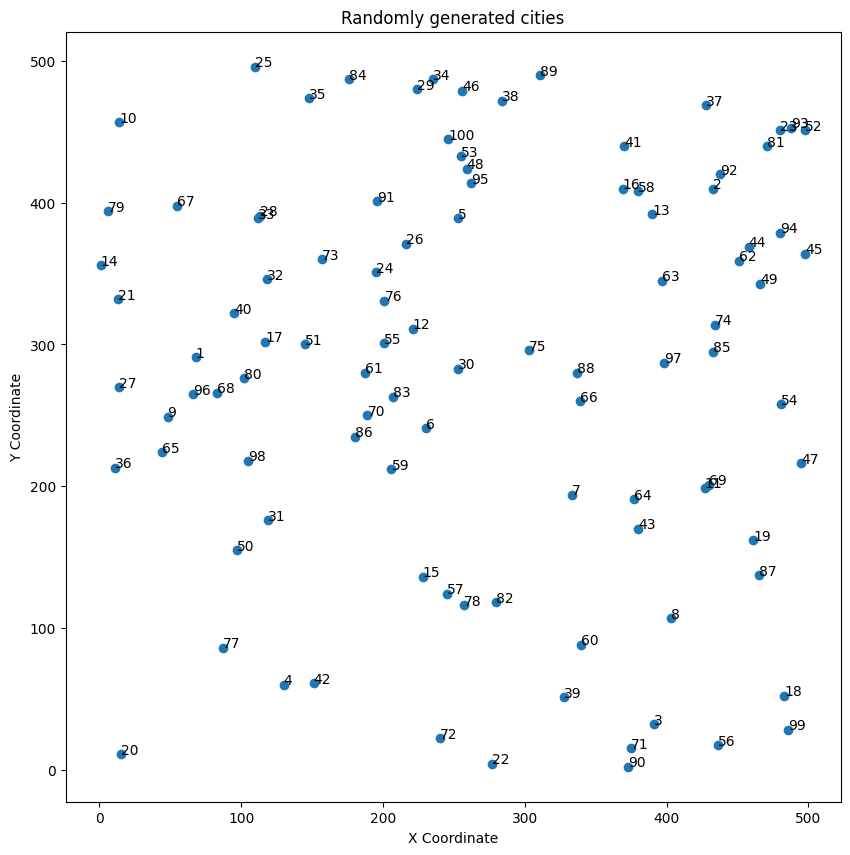

In [123]:
nb_nodes = 100
x_range = (0, 500)
y_range = (0, 500)

data = Cities(nb_nodes, x_range, y_range, 1)

center_city = data.getCenterCity()

graph = Graph(data=data.cities, title="Randomly generated cities")
graph.scatterPlot()

### 3. Clusturing

#### Create the ``kMeansClusters`` class

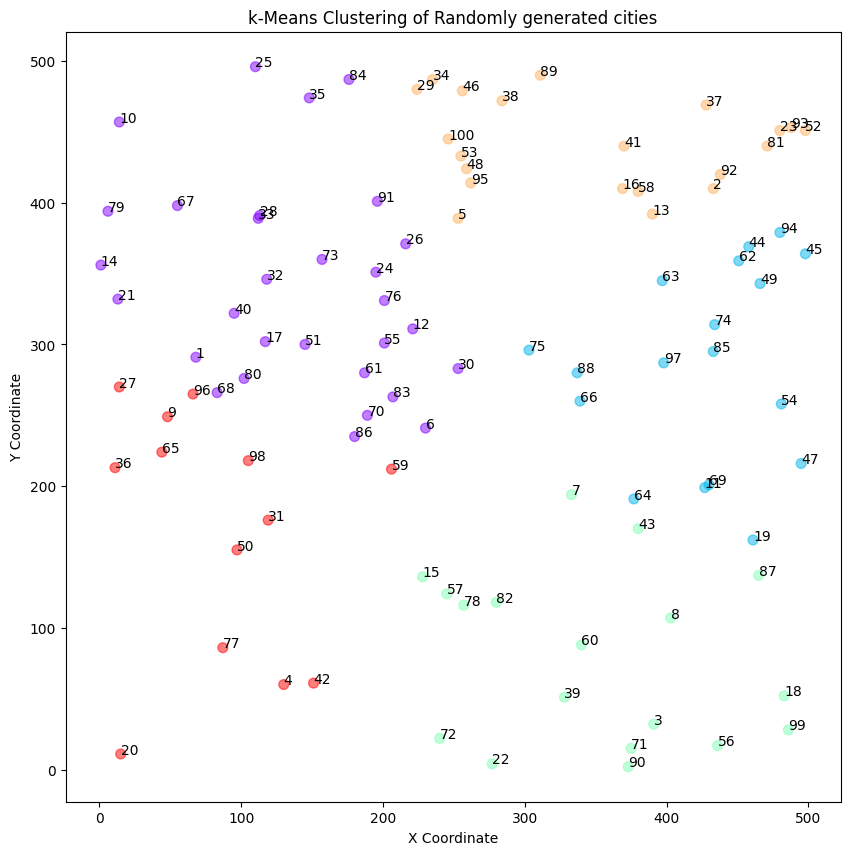

In [124]:
class kMeansClusters:
    def __init__(self, k: int, data: tuple[int, int, int]) -> None:
        self.k = k
        self.data = data
        self.coordinates = np.array([(x, y) for n, x, y in data])
        self.kmeans = KMeans(n_clusters=k, random_state=0)
        self.__fit()

    def __fit(self) -> None:
        self.clusters = self.kmeans.fit_predict(self.coordinates)

    def getClusters(self) -> np.ndarray:
        return self.clusters

    def getCitiesByCluster(self) -> list[list[tuple[int, int, int]]]:
        cities_clusters = [[] for _ in range(self.k)]
        for i in range(self.k):
            for j in range(len(self.clusters)):
                if self.clusters[j] == i:
                    cities_clusters[i].append(self.data[j])
        return cities_clusters


k = 5
k_means = kMeansClusters(k, data.cities)
clusters = k_means.getClusters()
cities_clusters = k_means.getCitiesByCluster()

graph = Graph(data=data.cities, title="k-Means Clustering of Randomly generated cities")
graph.scatterPlot(c=clusters, cmap='rainbow', s=50, alpha=0.5)

### 4. Algorithmes

#### Programmation linéaire

Total distance: 22280.235751622688


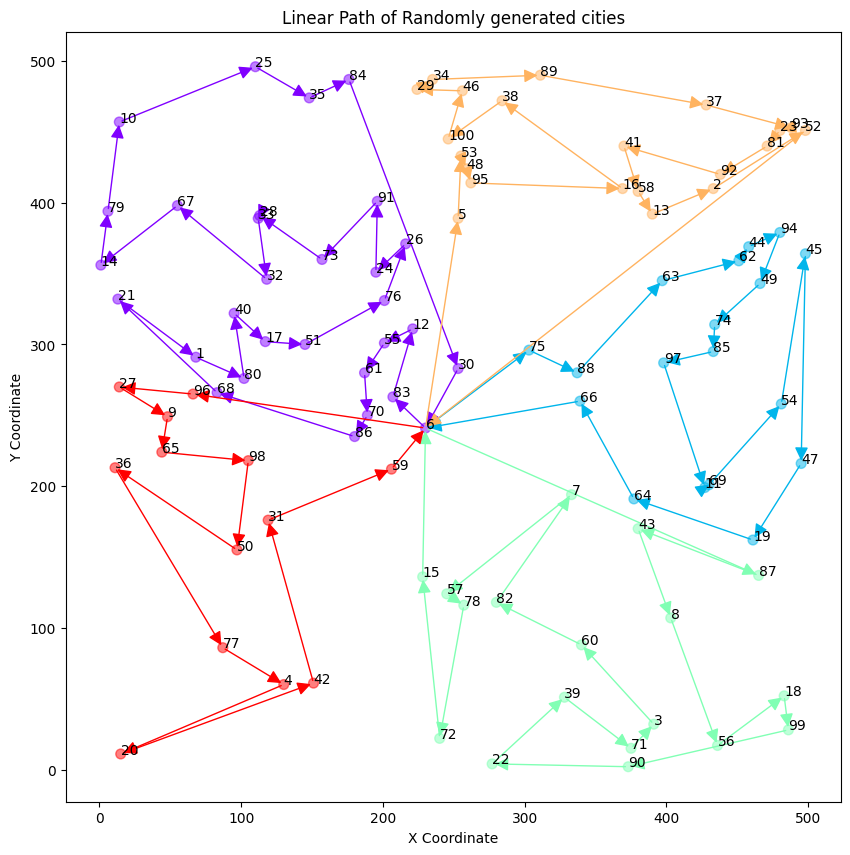

In [126]:
class LinearProgramming():
    def __init__(self, cities: Cities) -> None:
        """
        Initialize the Linear Programming solver.

        :param cities: Instance of the Cities class
        """
        self.cities = cities

    def __getCyclePulp(self, vertexs: list[tuple[int, int, int]], all_edges: list[tuple[int, int]], all_weighed_edges: dict[tuple[int, int], float]) -> list[tuple[int, int, int]]:
        """
        Solve the TSP problem using Pulp.

        :param vertexs: List of all the vertices
        :param all_edges: List of all the edges
        :param all_weighed_edges: Dictionary of all the edges and their weight
        :return: List of vertices representing a cycle
        """
        # List of all the vertexs
        all_vertexs = [i for i in range(len(vertexs))]

        # Decisions variables
        x = pulp.LpVariable.dicts('x', all_edges, cat=pulp.LpBinary)
        u = pulp.LpVariable.dicts('u', all_vertexs, lowBound=1, upBound=len(all_vertexs), cat=pulp.LpInteger)

        # Model creation
        model = pulp.LpProblem("TSP", pulp.LpMinimize)

        # Objective function (we multiply the edges by their weight)
        model += pulp.lpSum(x[i, j]*all_weighed_edges[i, j] for (i, j) in all_edges)

        # Degree constraints
        for current_vertex in all_vertexs:
            # We need to have exactly 1 outgoing edge
            model += pulp.lpSum(x[i, k] for (i, k) in all_edges if i==current_vertex) == 1
            # We need to have exactly 1 incoming edge
            model += pulp.lpSum(x[i, k] for (k, i) in all_edges if k==current_vertex) == 1

        # SubTour elimination
        n = len(all_vertexs)
        for (i, j) in all_edges:
            # Avoid defining a constraint for the starting vertex
            if i != 0 and j != 0:
                # This constraint eliminates SubTour
                model += u[i] - u[j] + n * x[i, j] <= n - 1, f"SEC_{i}_{j}"

        # Fix the starting vertex
        model += u[0] == 1, "Start"

        # Solve the model
        solver = pulp.PULP_CBC_CMD(msg=0)
        model.solve(solver)

        # We store all the chosen edges
        result = {}
        for (i, j) in all_edges:
            if pulp.value(x[i, j]) == 1:
                result[i] = (i, j)

        # We return the list of edges in the format: [(vertex_i, position_x_i, position_y_i)]
        final_result = []
        next_visited = 0
        (i, j) = (0, 0)
        for t in range (len(result)+1):
            (i, j) = result[next_visited]
            final_result.append((i+1, vertexs[i][1], vertexs[i][2]))
            next_visited = j
        return final_result, pulp.value(model.objective)


    def __getCycleGurobi(self, vertexs: list[tuple[int, int, int]], all_edges: list[tuple[int, int]], all_weighed_edges: dict[tuple[int, int], float]) -> list[tuple[int, int, int]]:
        """
        Solve the TSP problem using Gurobi

        :param vertexs: List of all the vertices
        :param all_edges: List of all the edges
        :param all_weighed_edges: Dictionary of all the edges and their weight
        :return: List of vertices representing a cycle
        """
        # List of all the vertexs
        all_vertex  = [i for i in range(len(vertexs))]

        # Decisions variables
        model = gp.Model("TSP")
        model.setParam('OutputFlag', 0)
        x = model.addVars(all_edges, vtype=GRB.BINARY, name="x")
        u = model.addVars(all_vertex, lb=1, ub=len(all_vertex), vtype=GRB.INTEGER, name='u')

        # Objective function (we multiply the edges by their weight)
        model.setObjective(gp.quicksum(x[i, j]*all_weighed_edges[i, j] for (i, j) in all_edges), GRB.MINIMIZE)

        # Degree constraints
        for sommet in all_vertex:
            # We need to have exactly 1 outgoing edge
            model.addConstr(gp.quicksum(x[i, k] for (i, k) in all_edges if i==sommet) == 1)
            # We need to have exactly 1 incoming edge
            model.addConstr(gp.quicksum(x[i, k] for (k, i) in all_edges if k==sommet) == 1)

        # SubTour elimination
        n = len(all_vertex)
        for (i, j) in all_edges:
            # Avoid defining a constraint for the starting vertex
            if i != 0 and j != 0:
                model.addConstr(u[i] - u[j] + n * x[i, j] <= n - 1, f"SEC_{i}_{j}")
        model.addConstr(u[0] == 1, "Start")
        model.optimize()

        # We store all the chosen edges
        result = {}
        for (i, j) in all_edges:
            if x[i, j].X > 0.5:
                result[i] = (i, j)

        # We return the list of edges in the format: [(vertex_i, position_x_i, position_y_i)]
        final_result = []
        next_visited = 0
        (i, j) = (0, 0)
        for t in range (len(result)+1):
            (i, j) = result[next_visited]
            final_result.append((i+1, vertexs[i][1], vertexs[i][2]))
            next_visited = j
        return final_result, model.ObjVal


    def __createConnexeGraph(self, all_cities: list[tuple[int, int, int]]) -> list[tuple[int, int]]:
        """
        Create a connexe graph using Delaunay triangulation.

        :param all_cities: List of all the vertices
        :return: List of edges
        """
        # List of positions corresponding to the cities
        points = []
        for i in all_cities:
            points.append((i[1], i[2]))

        # Delaunay triangulation
        tri = Delaunay(points)
        G = nx.Graph()

        # Add vertex to the graph
        for i, point in enumerate(points):
            G.add_node(i, pos=(point[0], point[1]))

        # Add edges to the graph based on the Delaunay triangulation
        for simplex in tri.simplices:
            for i in range(3):
                for j in range(i+1, 3):
                    G.add_edge(simplex[i], simplex[j])

        # Return all the edges
        result = []
        for i in G.edges():
            result.append(i)
            result.append((i[1], i[0]))
        return result


    def __startGettingBestChemin(self, nodes: list[tuple[int, int, int]], choice_solve: str="GUROBIPY") -> tuple[list[tuple[int, int, int]], float]:
        """
        Start getting the best path.

        :param nodes: List of all the vertices
        :param choice_solve: String to know which solver to use (PULP, GUROBIPY)
        :return: List of vertices representing a cycle, total distance
        """
        all_edges = []
        weighed_edges = {}
        # Create a connexe graph
        all_edges = self.__createConnexeGraph(nodes)

        # Create weighed edges
        for (i, j) in all_edges:
            weighed_edges[(i, j)] = self.cities.calculateDistance(i, j)

        if choice_solve == "GUROBIPY":
            best_cycle, value = self.__getCycleGurobi(nodes, all_edges, weighed_edges)
        else:
            best_cycle, value = self.__getCyclePulp(nodes, all_edges, weighed_edges)
        return best_cycle, value

    def processClusters(self, cities_clusters: list[list[tuple[int, int, int]]], center_city: tuple[int, int, int]) -> tuple[list[tuple[int, int, int]], float]:
        """
        Process the clusters.

        :param cities_clusters: List of all the clusters
        :return: List of vertices representing a cycle, total distance
        """
        cluster_linear_path = []
        total_distance = 0
        for cluster_idx, cluster in enumerate(cities_clusters):
            if center_city in cluster:
                cluster.remove(center_city)
            cluster.append(center_city)
            chemin, value = self.__startGettingBestChemin(cluster, "GUROBIPY")
            total_distance += value
            cluster_linear_path.append(chemin)
        return cluster_linear_path, total_distance


lp_solver = LinearProgramming(data)
cluster_linear_path, total_distance = lp_solver.processClusters(cities_clusters, center_city)

print(f"Total distance: {total_distance}")

graph = Graph(data=data.cities, title="Linear Path of Randomly generated cities")
graph.scatterPlot(c=clusters, cmap='rainbow', s=50, alpha=0.5, arrow=cluster_linear_path)

#### Algorithme glouton (greedy)

L'algorithme glouton résout les problèmes en faisant des choix locaux optimaux à chaque étape pour espérer atteindre une solution globale optimale. Le code ci-dessous montre cette approche : on commence par une ville de départ, on trouve la ville non visitée la plus proche, la visite, et répète ce processus jusqu'à ce que toutes les villes soient visitées, puis on retourne à la ville de départ pour compléter le cycle. Ce processus est appliqué à des clusters de villes, incluant une ville centrale dans chaque cluster.

Schéma exemple de Greedy :

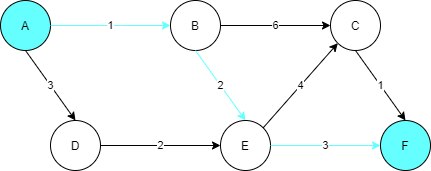

Total distance: 5856.968496941388


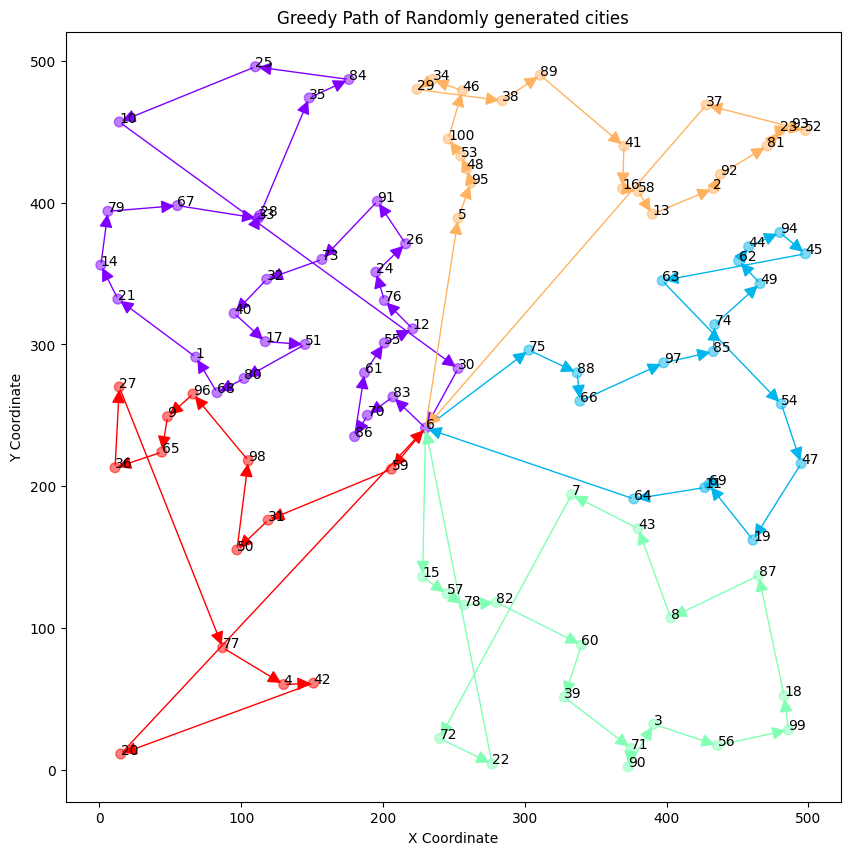

In [125]:
class Greedy:
    def __init__(self, cities: Cities) -> None:
        """
        Initialize the Greedy object with city information.

        :param cities: Instance containing city information and methods to calculate distances.
        """
        self.cities = cities

    def __greedyPath(self, nodes: list[tuple[str, int, int]], start: str) -> tuple[list[tuple[str, int, int]], float]:
        """
        Calculate the path using a greedy approach starting from a given point.

        :param nodes: List of tuples representing cities in the form (name, x-coordinate, y-coordinate).
        :param start: Starting city.
        :return: Tuple containing the calculated path as a list and the total distance traveled.
        """
        # Convert nodes to a dictionary for quick access
        self.nodes = {node[0]: (node[1], node[2]) for node in nodes}
        visited = set()
        unvisited = set(self.nodes.keys())
        path = [(start, *self.nodes[start])]
        current = start
        visited.add(current)
        unvisited.remove(current)
        total_distance = 0

        while unvisited:
            next_node = None
            min_distance = float('inf')
            # Find the closest unvisited city
            for node in unvisited:
                distance = self.cities.calculateDistance(current, node)
                if distance < min_distance:
                    min_distance = distance
                    next_node = node
            total_distance += min_distance
            current = next_node
            path.append((current, *self.nodes[current]))
            visited.add(current)
            unvisited.remove(current)

        # Return to the starting city to complete the cycle
        path.append((start, *self.nodes[start]))
        total_distance += self.cities.calculateDistance(current, start)
        return path, total_distance

    def processClusters(self, cities_clusters: list[list[tuple[str, int, int]]], center_city: str) -> tuple[list[list[tuple[str, int, int]]], float]:
        """
        Process clusters of cities and calculate the greedy path for each cluster.

        :param cities_clusters: List of clusters, each cluster being a list of tuples (name, x-coordinate, y-coordinate).
        :param center_city: The central city to include in each cluster.
        :return: Tuple containing the greedy paths for each cluster and the total distance traveled.
        """
        cluster_greedy_path = []
        total_distance = 0
        for cluster_idx, cluster in enumerate(cities_clusters):
            if center_city in cluster:
                cluster.remove(center_city)
            cluster.append(center_city)
            path, distance = self.__greedyPath(cluster, cluster[-1][0])
            cluster_greedy_path.append(path)
            total_distance += distance
        return cluster_greedy_path, total_distance

# Usage
greedy_solver = Greedy(data)
cluster_greedy_paths, total_distance = greedy_solver.processClusters(cities_clusters, center_city)

print(f"Total distance: {total_distance}")

graph = Graph(data=data.cities, title="Greedy Path of Randomly generated cities")
graph.scatterPlot(c=clusters, cmap='rainbow', s=50, alpha=0.5, arrow=cluster_greedy_paths)

### 5. Étude expérimentale

## Stats

In [127]:
def solutionStats(cls, title: str, nb_iteration, taille_min, taille_max, taille_step, k_values) -> None:
    # Create an array to store durations in function of the size of the graph and the k value
    durees = np.zeros((len(k_values), (taille_max - taille_min) // taille_step))
    distances = np.zeros((len(k_values), (taille_max - taille_min) // taille_step))

    # on affiche la barre de progression
    nb_tests = ((taille_max - taille_min) / taille_step) * nb_iteration * len(k_values)
    bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
    display(bar)

    for taille in range(taille_min, taille_max, taille_step):
        duree_moy   = 0.0
        distance_moy = 0.0
        for k in k_values:
            for i in range(nb_iteration):
                algo_data = Cities(taille, x_range, y_range)
                center_city = algo_data.getCenterCity()
                k_means = kMeansClusters(k, algo_data.cities)
                cities_clusters = k_means.getCitiesByCluster()
                algo_solver = cls(algo_data)
                start = time.time()
                cluster_algo_paths, total_distance = algo_solver.processClusters(cities_clusters, center_city)
                stop = time.time()
                duree = stop - start

                duree_moy += duree
                distance_moy += total_distance
                bar.value += 1

            durees[k_values.index(k)][(taille - taille_min) // taille_step] = duree_moy / nb_iteration
            distances[k_values.index(k)][(taille - taille_min) // taille_step] = distance_moy / nb_iteration
    # on cache la barre de progression
    bar.close()

    # on règle l'affichage des courbes
    tailles = [x for x in range(taille_min, taille_max, taille_step)]
    plt.figure(figsize=(20,10))

    plt.xlabel('Taille du graphe (nombre de sommets)')
    plt.xticks(ticks=tailles) # valeurs affichées sur l'axe X
    plt.ylabel('Temps de calcul (en s)')
    plt.title(title)
    for i in range(len(k_values)):
        plt.plot(tailles, durees[i], label=f'k={k_values[i]}')

    # on affiche
    plt.legend()
    plt.show()

    plt.figure(figsize=(20,10))

    plt.xlabel('Taille du graphe (nombre de sommets)')
    plt.xticks(ticks=tailles) # valeurs affichées sur l'axe X
    plt.ylabel('Distance parcourue')
    plt.title(title)
    for i in range(len(k_values)):
        plt.plot(tailles, distances[i], label=f'k={k_values[i]}')

    # on affiche
    plt.legend()
    plt.show()

IntProgress(value=0, layout=Layout(width='100%'), max=280)

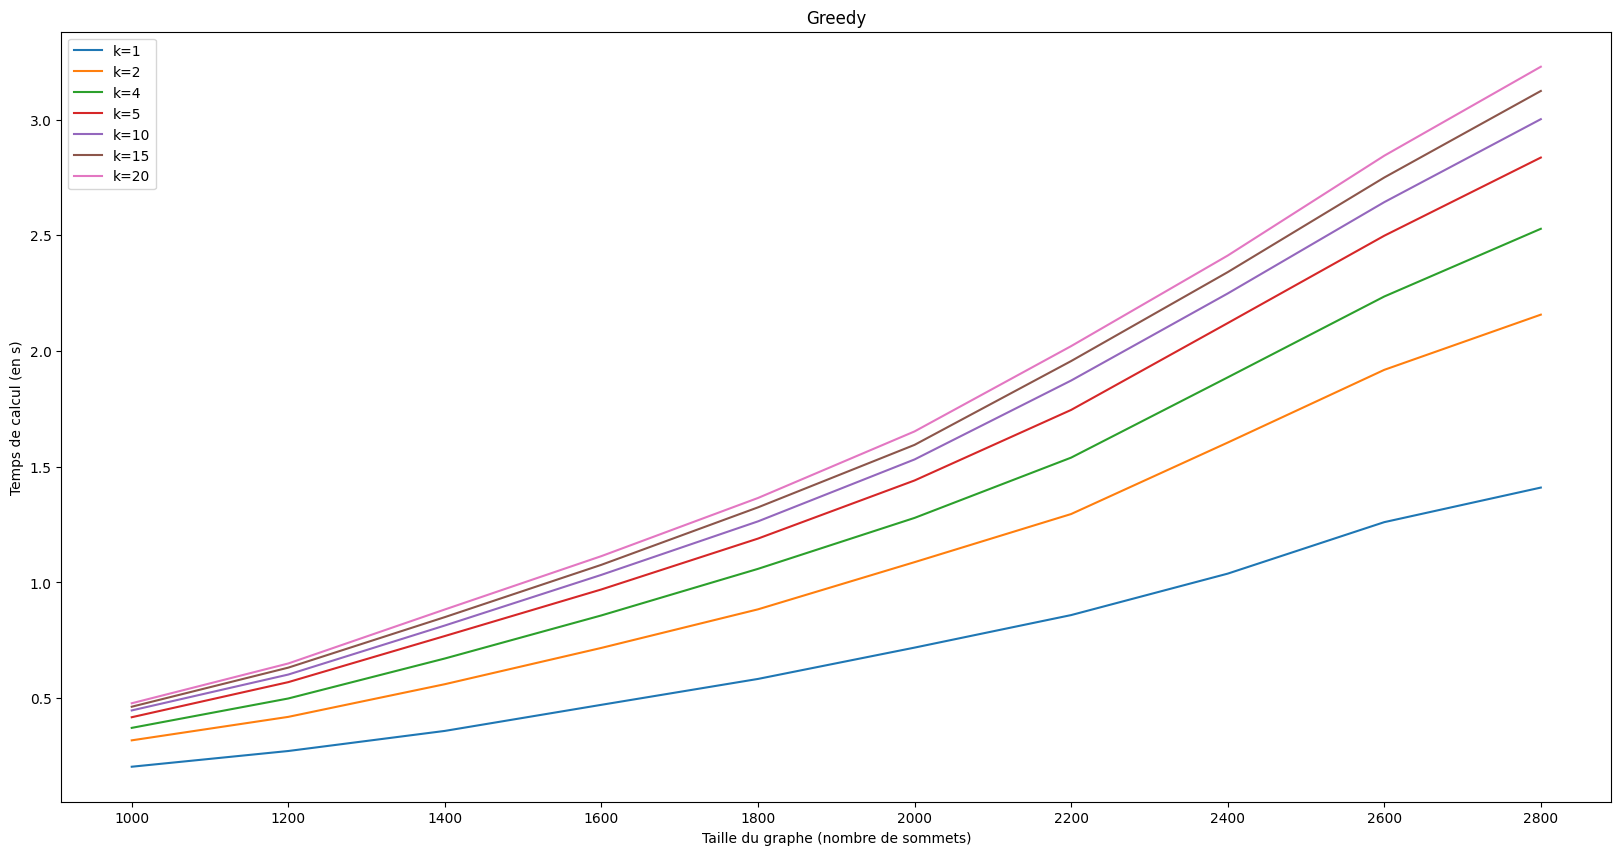

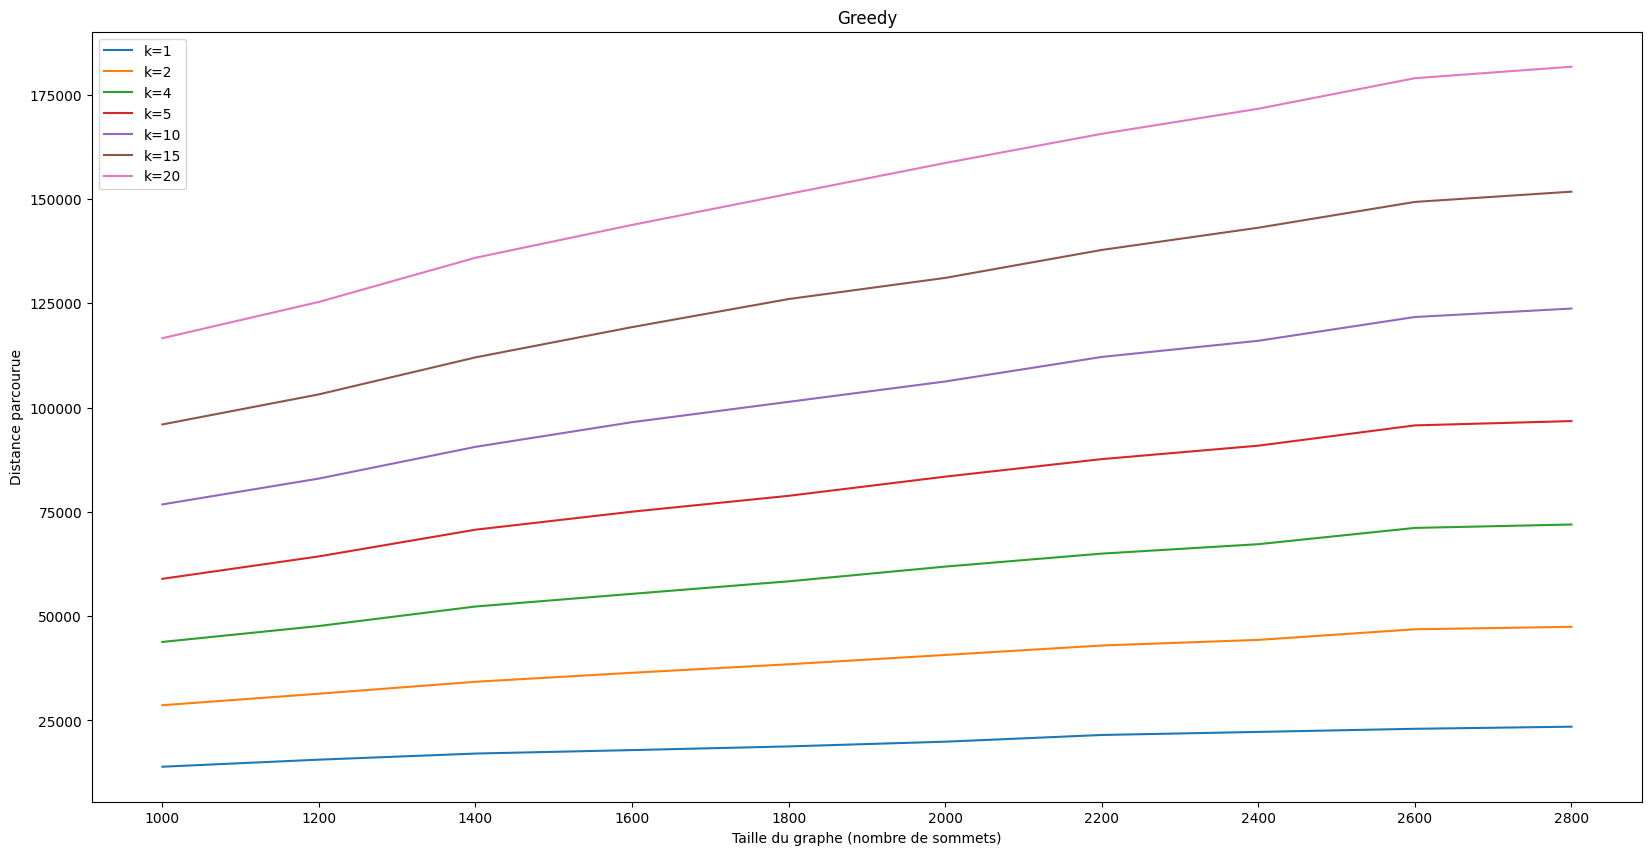

In [128]:
nb_iteration = 4
taille_min   = 1000
taille_max   = 3000
taille_step  = 200
k_values     = [1, 2, 4, 5, 10, 15, 20]

solutionStats(Greedy, "Greedy", nb_iteration, taille_min, taille_max, taille_step, k_values)

In [129]:
nb_iteration = 3
taille_min   = 40
taille_max   = 100
taille_step  = 10
k_values     = [1, 2, 3]

solutionStats(LinearProgramming, "Linear Programming", nb_iteration, taille_min, taille_max, taille_step, k_values)

IntProgress(value=0, layout=Layout(width='100%'), max=54)

GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information